In [5]:
import torch
from PIL import Image
import numpy as np
import torchvision.models as models
import os
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

## Loading images

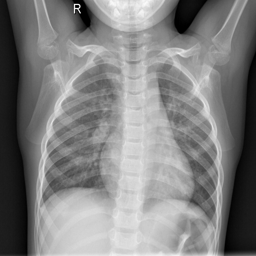

In [14]:
img = Image.open('chest_xray/train/NORMAL/IM-0115-0001.jpeg').convert("RGB")
img.resize((256, 256))

In [6]:
X = np.array(img.resize((224, 224)))
X

array([[[ 22,  22,  22],
        [ 20,  20,  20],
        [ 19,  19,  19],
        ...,
        [ 95,  95,  95],
        [ 95,  95,  95],
        [ 95,  95,  95]],

       [[ 22,  22,  22],
        [ 21,  21,  21],
        [ 19,  19,  19],
        ...,
        [ 93,  93,  93],
        [ 95,  95,  95],
        [ 95,  95,  95]],

       [[ 23,  23,  23],
        [ 21,  21,  21],
        [ 19,  19,  19],
        ...,
        [ 94,  94,  94],
        [ 94,  94,  94],
        [ 93,  93,  93]],

       ...,

       [[ 29,  29,  29],
        [ 29,  29,  29],
        [ 27,  27,  27],
        ...,
        [ 59,  59,  59],
        [ 60,  60,  60],
        [ 60,  60,  60]],

       [[ 34,  34,  34],
        [ 35,  35,  35],
        [ 34,  34,  34],
        ...,
        [ 80,  80,  80],
        [ 82,  82,  82],
        [ 82,  82,  82]],

       [[ 46,  46,  46],
        [ 46,  46,  46],
        [ 45,  45,  45],
        ...,
        [109, 109, 109],
        [110, 110, 110],
        [111, 111, 111]]

In [7]:
X.shape

(224, 224, 3)

## Exploratory Data Analysis

In [10]:
class ChestXrayDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        for label_name in self.classes:
            label_dir = os.path.join(data_dir, label_name)
            for img_name in os.listdir(label_dir):
                self.image_paths.append(os.path.join(label_dir, img_name))
                self.labels.append(self.class_to_idx[label_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [11]:
input_size = 224

# ImageNet normalization values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Simple transforms - just resize and normalize
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),           # Rotate up to 10 degrees
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),  # Zoom
    transforms.RandomHorizontalFlip(),       # Horizontal flip
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
val_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [12]:
train_dataset = ChestXrayDataset(data_dir='./chest_xray/train',transform=train_transforms)
val_dataset = ChestXrayDataset( data_dir='./chest_xray/test', transform=test_transforms ) # Using test as val data on purpose cause val dataset is too small

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Train images:", len(train_dataset))
print("Val images:", len(val_dataset))

Train images: 5216
Val images: 624


In [11]:
from collections import Counter

no_train_images = Counter(train_dataset.labels)
no_val_images = Counter(val_dataset.labels)

train_counts = dict(no_train_images)
val_counts = dict(no_val_images)

print("Train images:", train_counts)
print("Val images:", val_counts)

Train images: {0: 1341, 1: 3875}
Val images: {0: 234, 1: 390}


In [12]:
label_map = {
    0: 'NORMAL',
    1: 'PNEUMONIA'
}

label_map = {i: cls for i, cls in enumerate(train_dataset.classes)} #Since ChestXrayDataset looks like this 'self.labels = [...]' internally

def convert_counts(counter, label_map):
    return {label_map[k]: v for k, v in counter.items()}

print("Train images:", convert_counts(no_train_images, label_map))
print("Val images:", convert_counts(no_val_images, label_map))

# Alternatively
# This take quite some time to run compared to the code in previous cell
# from collections import Counter

# def dataset_class_counts(dataset):
#     labels = [dataset[i][1] for i in range(len(dataset))]
#     return Counter(labels)

# train_counts = dataset_class_counts(train_dataset)
# val_counts = dataset_class_counts(val_dataset)

# def map_counter(counter, label_map):
#     return {label_map[k]: v for k, v in counter.items()}

# print("Train:", map_counter(train_counts, label_map))
# print("Val:", map_counter(val_counts, label_map))

Train images: {'NORMAL': 1341, 'PNEUMONIA': 3875}
Val images: {'NORMAL': 234, 'PNEUMONIA': 390}


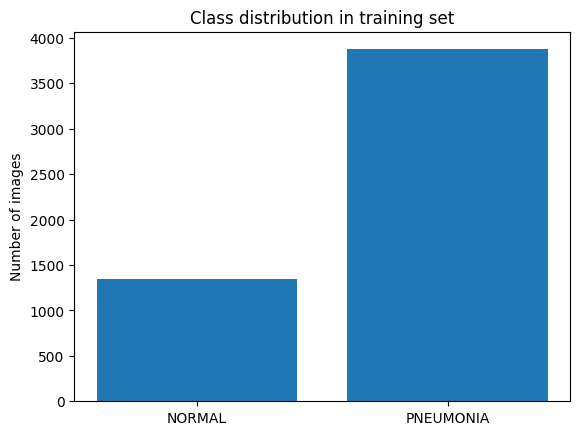

In [13]:
import matplotlib.pyplot as plt

labels = ["NORMAL", "PNEUMONIA"]
counts = [train_counts[0], train_counts[1]]

plt.bar(labels, counts)
plt.title("Class distribution in training set")
plt.ylabel("Number of images")
plt.show()

## Using a Pre-trained convolutional neural network to make a prediction

In [14]:
model = models.densenet121(weights='IMAGENET1K_V1')

model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [15]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [16]:
x = preprocess(img)

batch_t = torch.unsqueeze(x, 0)

with torch.no_grad():
    output = model(batch_t)

_, indices = torch.sort(output, descending=True)

In [17]:
print(output)

tensor([[-2.8715e+00,  3.8927e+00, -1.0102e+00,  2.3180e+00,  1.9180e+00,
         -1.0565e+00,  4.9439e-02, -1.7771e+00, -1.6013e+00, -7.6558e-01,
         -2.7442e+00, -1.9195e+00,  1.0781e+00, -6.9439e-01, -2.5104e+00,
         -7.3937e-01, -3.5466e-01, -1.8304e+00, -2.4610e+00,  5.0528e-01,
         -2.3011e+00,  1.4777e-01, -1.4341e+00,  3.2514e-01, -1.6196e+00,
         -1.3461e+00, -2.1923e+00, -1.9644e+00, -1.5232e+00,  1.7120e+00,
         -3.1117e+00, -1.9013e+00, -2.1998e+00,  2.2648e+00,  1.8946e+00,
          3.9886e-02,  1.4756e-01,  1.3765e+00,  3.1510e-01, -9.2376e-01,
         -2.7771e+00, -1.3557e+00, -2.6200e+00, -1.2351e+00,  8.2432e-01,
          1.6935e+00, -2.0618e+00, -1.7087e+00, -1.2426e+00, -3.3229e+00,
         -4.2160e-01, -7.2678e-01,  2.7007e+00,  4.7619e-01,  4.1384e+00,
          2.0010e+00,  2.4054e+00,  7.6868e-01,  2.2514e+00,  8.1854e-01,
          3.0976e+00,  2.1428e+00,  1.9054e+00,  7.1661e+00,  3.2819e+00,
          9.6789e-01,  2.2421e+00,  3.

In [18]:
output_np = output.detach().cpu().numpy()
print(len(output_np[0]))

1000


As seen from the output of the previous cell, the pretrained DenseNet model outputs a 1×1000 tensor of logits, where each value represents the model’s raw score for one of the 1000 ImageNet classes. The class with the highest score is the model’s predicted class. Adapting the model to our use case in this project which requires only 2 output classes, normal or pneumonia leads us to transfer learning

## Transfer learning: adding custom output layer to the pre-trained CNN

In [6]:
class ChestXrayClassifierDenseNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ChestXrayClassifierDenseNet, self).__init__()

        # Load pre-trained DenseNetV2
        self.base_model = models.densenet121(weights='IMAGENET1K_V1')

        # Freeze base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Remove original classifier
        self.base_model.classifier = nn.Identity()

        # Add custom layers
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.output_layer = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.output_layer(x)
        return x

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ChestXrayClassifierDenseNet(num_classes=2)
model.to(device)

ChestXrayClassifierDenseNet(
  (base_model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, 

In [21]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [ ]:
# Training loop
num_epochs = 6

for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over the training data
    for inputs, labels in train_loader:
        # Move data to the specified device (GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients to prevent accumulation
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        # Calculate the loss
        loss = criterion(outputs, labels)
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        running_loss += loss.item()
        # Get predictions
        _, predicted = torch.max(outputs.data, 1)
        # Update total and correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average training loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    # Disable gradient calculation for validation
    with torch.no_grad():
        # Iterate over the validation data
        for inputs, labels in val_loader:
            # Move data to the specified device (GPU or CPU)
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass
            outputs = model(inputs)
            # Calculate the loss
            loss = criterion(outputs, labels)

            # Accumulate validation loss
            val_loss += loss.item()
            # Get predictions
            _, predicted = torch.max(outputs.data, 1)
            # Update total and correct predictions
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy
    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    # Print epoch results
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

Epoch 1/6
  Train Loss: 0.1854, Train Acc: 0.9317
  Val Loss: 0.4665, Val Acc: 0.8638
Epoch 2/6
  Train Loss: 0.1689, Train Acc: 0.9415
  Val Loss: 0.5094, Val Acc: 0.8574
Epoch 3/6
  Train Loss: 0.1533, Train Acc: 0.9494
  Val Loss: 0.4493, Val Acc: 0.8878
Epoch 4/6
  Train Loss: 0.2141, Train Acc: 0.9417
  Val Loss: 0.6201, Val Acc: 0.8686
Epoch 5/6
  Train Loss: 0.1684, Train Acc: 0.9532
  Val Loss: 0.5236, Val Acc: 0.8910
Epoch 6/6
  Train Loss: 0.1483, Train Acc: 0.9538
  Val Loss: 0.6688, Val Acc: 0.8654


Since there is class imbalance, accuracy is not a reliable metric to measure the performance of our model

In [22]:
from sklearn.metrics import roc_auc_score

num_epochs = 6

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    all_labels_train = []
    all_probs_train = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Store labels and predicted probabilities for ROC AUC
        all_labels_train.extend(labels.cpu().numpy())
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Probabilities for class 1
        all_probs_train.extend(probs.detach().cpu().numpy())

    train_loss = running_loss / len(train_loader)
    train_roc = roc_auc_score(all_labels_train, all_probs_train)

    # Validation phase
    model.eval()
    val_loss = 0.0
    all_labels_val = []
    all_probs_val = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Store labels and predicted probabilities for ROC AUC
            all_labels_val.extend(labels.cpu().numpy())
            probs = torch.softmax(outputs, dim=1)[:, 1]
            all_probs_val.extend(probs.cpu().numpy())

    val_loss /= len(val_loader)
    val_roc = roc_auc_score(all_labels_val, all_probs_val)

    # Print epoch results
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'  Train Loss: {train_loss:.4f}, Train ROC AUC: {train_roc:.4f}')
    print(f'  Val Loss: {val_loss:.4f}, Val ROC AUC: {val_roc:.4f}')


Epoch 1/6
  Train Loss: 0.2267, Train ROC AUC: 0.9687
  Val Loss: 0.5148, Val ROC AUC: 0.9477
Epoch 2/6
  Train Loss: 0.1743, Train ROC AUC: 0.9821
  Val Loss: 0.5772, Val ROC AUC: 0.9516
Epoch 3/6
  Train Loss: 0.1785, Train ROC AUC: 0.9839
  Val Loss: 0.5426, Val ROC AUC: 0.9354
Epoch 4/6
  Train Loss: 0.1806, Train ROC AUC: 0.9846
  Val Loss: 1.0783, Val ROC AUC: 0.9578
Epoch 5/6
  Train Loss: 0.1822, Train ROC AUC: 0.9855
  Val Loss: 0.6457, Val ROC AUC: 0.9553
Epoch 6/6
  Train Loss: 0.1886, Train ROC AUC: 0.9845
  Val Loss: 0.4801, Val ROC AUC: 0.9483


In [23]:
def make_model(learning_rate=0.01):
    model = ChestXrayClassifierDenseNet(num_classes=2)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer

In [24]:
def train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device):
    best_val_roc = 0.0
    train_roc_list = []
    val_roc_list = []

    for epoch in range(num_epochs):
        # -------------------
        # Training phase
        # -------------------
        model.train()
        all_labels_train = []
        all_probs_train = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            all_labels_train.extend(labels.cpu().numpy())
            probs = torch.softmax(outputs, dim=1)[:, 1]
            all_probs_train.extend(probs.detach().cpu().numpy())

        train_roc = roc_auc_score(all_labels_train, all_probs_train)
        train_roc_list.append(train_roc)

        # -------------------
        # Validation phase
        # -------------------
        model.eval()
        all_labels_val = []
        all_probs_val = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                all_labels_val.extend(labels.cpu().numpy())
                probs = torch.softmax(outputs, dim=1)[:, 1]
                all_probs_val.extend(probs.cpu().numpy())

        val_roc = roc_auc_score(all_labels_val, all_probs_val)
        val_roc_list.append(val_roc)

        print(f'Epoch {epoch+1}/{num_epochs} | Train ROC: {train_roc:.4f} | Val ROC: {val_roc:.4f}')
        
        # Save the best model based on validation ROC AUC
        if val_roc > best_val_roc:
            best_val_roc = val_roc
            checkpoint_path = f'model_best_roc_epoch{epoch+1:02d}_{val_roc:.3f}.pth'
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Checkpoint saved: {checkpoint_path}')

    return train_roc_list, val_roc_list

## Learning Rate tuning

In [25]:
learning_rates = [0.001, 0.1, 1, 10]
num_epochs = 3

all_train_rocs = {}
all_val_rocs = {}

for lr in learning_rates:
    print(f"\nTraining with learning rate = {lr}")

    # Use your make_model function to get model and optimizer
    model, optimizer = make_model(lr)
    model = model.to(device)

    # Train and get ROC AUC lists
    train_roc_list, val_roc_list = train_and_evaluate(
        model, optimizer, train_loader, val_loader, criterion, num_epochs, device
    )

    # Store results for plotting
    all_train_rocs[lr] = train_roc_list
    all_val_rocs[lr] = val_roc_list


Training with learning rate = 0.001
Epoch 1/3 | Train ROC: 0.9670 | Val ROC: 0.9416
Checkpoint saved: model_best_roc_epoch01_0.942.pth
Epoch 2/3 | Train ROC: 0.9832 | Val ROC: 0.9486
Checkpoint saved: model_best_roc_epoch02_0.949.pth
Epoch 3/3 | Train ROC: 0.9882 | Val ROC: 0.9526
Checkpoint saved: model_best_roc_epoch03_0.953.pth

Training with learning rate = 0.1
Epoch 1/3 | Train ROC: 0.9484 | Val ROC: 0.9162
Checkpoint saved: model_best_roc_epoch01_0.916.pth
Epoch 2/3 | Train ROC: 0.9470 | Val ROC: 0.8015
Epoch 3/3 | Train ROC: 0.9476 | Val ROC: 0.8501

Training with learning rate = 1
Epoch 1/3 | Train ROC: 0.9056 | Val ROC: 0.8895
Checkpoint saved: model_best_roc_epoch01_0.890.pth
Epoch 2/3 | Train ROC: 0.9211 | Val ROC: 0.8066
Epoch 3/3 | Train ROC: 0.9234 | Val ROC: 0.6640

Training with learning rate = 10
Epoch 1/3 | Train ROC: 0.8903 | Val ROC: 0.7314
Checkpoint saved: model_best_roc_epoch01_0.731.pth
Epoch 2/3 | Train ROC: 0.9053 | Val ROC: 0.7517
Checkpoint saved: model_bes

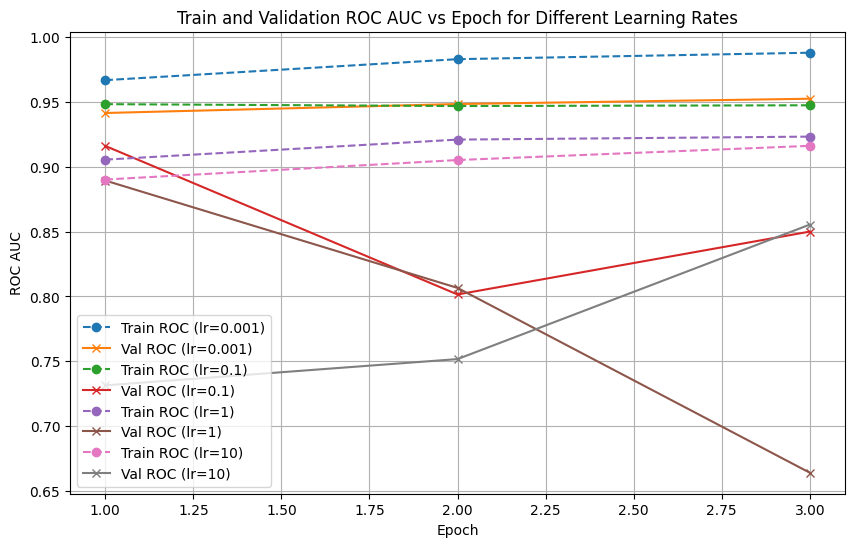

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for lr in learning_rates:
    plt.plot(range(1, num_epochs+1), all_train_rocs[lr], label=f'Train ROC (lr={lr})', linestyle='--', marker='o')
    plt.plot(range(1, num_epochs+1), all_val_rocs[lr], label=f'Val ROC (lr={lr})', linestyle='-', marker='x')

plt.xlabel('Epoch')
plt.ylabel('ROC AUC')
plt.title('Train and Validation ROC AUC vs Epoch for Different Learning Rates')
plt.legend()
plt.grid(True)
plt.show()

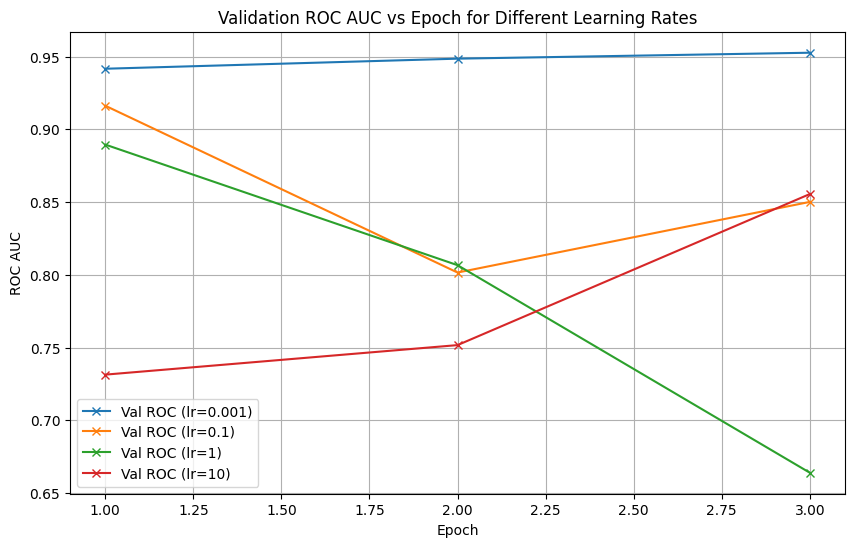

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for lr in learning_rates:
    plt.plot(range(1, num_epochs+1), all_val_rocs[lr], label=f'Val ROC (lr={lr})', linestyle='-', marker='x')

plt.xlabel('Epoch')
plt.ylabel('ROC AUC')
plt.title('Validation ROC AUC vs Epoch for Different Learning Rates')
plt.legend()
plt.grid(True)
plt.show()

As illustrated by the graphs, the best value of learning rate is 0.001

## Using Trained Model

In [ ]:
# import glob, os

# Find best checkpoint
# list_of_files = glob.glob('model_v4_*.pth')
# latest_file = max(list_of_files, key=os.path.getctime)
# print(f"Loading model from: {latest_file}")

Loading model from: model_v4_01_0.938.pth


In [ ]:
model_path = './model_best_roc_epoch03_0.953.pth'

# Load model
model = ChestXrayClassifierDenseNet(num_classes=2)
model.load_state_dict(torch.load(model_path))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

ChestXrayClassifierDenseNet(
  (base_model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, 

In [15]:
x = val_transforms(img)
batch_t = torch.unsqueeze(x, 0).to(device)

with torch.no_grad():
    output = model(batch_t)

In [16]:
print(output)

tensor([[ 1.6364, -1.8568]], device='cuda:0')


In [17]:
classes = ['NORMAL', 'PNEUMONIA']

In [18]:
dict(zip(classes, output[0].to('cpu')))

{'NORMAL': tensor(1.6364), 'PNEUMONIA': tensor(-1.8568)}

In [19]:
import numpy as np

from keras_image_helper import create_preprocessor

In [20]:
def preprocess_pytorch(X):
    # X: shape (1, 299, 299, 3), dtype=float32, values in [0, 255]
    X = X / 255.0

    mean = np.array([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
    std = np.array([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1)

    # Convert NHWC → NCHW
    # from (batch, height, width, channels) → (batch, channels, height, width)
    X = X.transpose(0, 3, 1, 2)

    # Normalize
    X = (X - mean) / std

    return X.astype(np.float32)


preprocessor = create_preprocessor(preprocess_pytorch, target_size=(224, 224))

In [21]:
url = 'https://raw.githubusercontent.com/Uthmanee/machine-learning-zoomcamp-capstone2/master/testImage.jpeg'
X = preprocessor.from_url(url)
X.shape

(1, 3, 224, 224)

In [ ]:
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Export to ONNX
onnx_path = "finalChestXrayModel.onnx"

torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    verbose=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    }
)

/tmp/ipykernel_56862/1054713666.py:6: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(


[torch.onnx] Obtain model graph for `ChestXrayClassifierDenseNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ChestXrayClassifierDenseNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


/usr/lib/python3.12/copyreg.py:99: FutureWarning: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
  return cls.__new__(cls, *args)


[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 180 of general pattern rewrite rules.


ONNXProgram(
    model=
        <
            ir_version=10,
            opset_imports={'': 20},
            producer_name='pytorch',
            producer_version='2.10.0+cu128',
            domain=None,
            model_version=None,
        >
        graph(
            name=main_graph,
            inputs=(
                %"input"<FLOAT,[batch_size,3,224,224]>
            ),
            outputs=(
                %"output"<FLOAT,[batch_size,2]>
            ),
            initializers=(
                %"base_model.features.conv0.weight"<FLOAT,[64,3,7,7]>{Tensor(...)},
                %"base_model.features.denseblock1.denselayer1.norm1.weight"<FLOAT,[64]>{TorchTensor(...)},
                %"base_model.features.denseblock1.denselayer1.norm1.bias"<FLOAT,[64]>{TorchTensor(...)},
                %"base_model.features.denseblock1.denselayer1.conv1.weight"<FLOAT,[128,64,1,1]>{Tensor(...)},
                %"base_model.features.denseblock1.denselayer1.conv2.weight"<FLOAT,[32,128,3,3]>{Torch

In [28]:
import onnxruntime as ort

onnx_model_path = "finalChestXrayModel.onnx"
session = ort.InferenceSession(onnx_model_path, providers=["CPUExecutionProvider"])

In [29]:
inputs = session.get_inputs()
outputs = session.get_outputs()

input_name = inputs[0].name
output_name = outputs[0].name

In [30]:
result = session.run([output_name], {input_name: X})
result

[array([[-1.7533567,  2.7462134]], dtype=float32)]

In [31]:
predictions = result[0][0].tolist()

dict(zip(classes
, predictions))

{'NORMAL': -1.753356695175171, 'PNEUMONIA': 2.746213436126709}